<a href="https://colab.research.google.com/github/janithcyapa/SmartHVAC/blob/main/Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install psychrolib

  Preparing metadata (setup.py) ... done
  Created wheel for psychrolib: filename=PsychroLib-2.5.0-py3-none-any.whl size=9766 sha256=f27cd7da62a9409b7af48afe8b86242945c3ffa77574e7b1039d47deac0e997a
  Stored in directory: /root/.cache/pip/wheels/db/56/d2/160fe5cd010497f465b750b273cc5596f7dbbd139622428d11
Successfully built psychrolib


# Inital Calculation

In [3]:
import psychrolib as psy
import numpy as np
import math

In [11]:
# Use SI units to standard
psy.SetUnitSystem(psy.SI)

In [ ]:
# Control Signal
Control_Air_AF = 0.5 # 0 ~ 1
Control_Vent_AF = 0.1 # 0 ~ 1
Control_Cooling_PW = 0.9 # 0 ~ 1
Control_Heeting_PW = 0.1 # 0 ~ 1

# Room COnfig
dt = 600 # s Time to simulate
N_Occ = 3 # Number of Occupants in the room
Q_Equ = 500 # W - Sensible Heat from Equipment/Lights
T_room = 25 # °C - Initial dry bulb temperature
RH_room = 0.5 # 0 ~ 1 - Initial reletive humidity
P_air = 101325        # Pa -  Atmospheric pressure (sea level)
L_room = 5 # m - Length of the room
W_room = 4 # m - Width of the room
H_room = 2.5 # m - Height of the room
A_window = 4 # m^2 - Area of the window
A_wall = (L_room + W_room) * H_room - A_window # m^2 - Area of the wall
V_room = L_room * W_room * H_room # m^3 - Volume of the room

# Room Conditions
# Humidity ratio
W_room = psy.GetHumRatioFromRelHum(T_room, RH_room, P_air) # kg water/kg dry air
# Enthalpy
h_room = psy.GetMoistAirEnthalpy(T_room, W_room ) # J/kg
h_fg_room = 2441000 # J/kg
# Air dencity
p_air = psy.GetMoistAirDensity(T_room, W_room, P_air)
# Specific heat of moist air
Cp_Air = 1005 # J/kg-K

# Weather Data
T_out = 35 # °C - Outside temperature
RH_out = 0.7 # 0 ~ 1 - Outside reletive humidity
W_out = psy.GetHumRatioFromRelHum(T_out, RH_out, P_air) # kg water/kg dry air

# AHU Config
Max_Air_FR = 0.1 # m^3/s Maximum airflow rate at maximum setting
P_fan = 5.0  # W Fan power
Max_Vent_FR = 0.1 # m^3/s Maximum ventilation airflow rate at maximum setting
Max_Cooling_PW = 2500 # W Maximum Cooling load of cooling pump
Max_Heating_PW = 1000 # W Maximum heating load of cooling pump

# Calculated Parameters
# Assume Air Flow, Cooling power and Heating power varies linearly with control input
Air_AF = Max_Air_FR * Control_Air_AF # m^3/s
Vent_AF = Max_Air_FR * Control_Vent_AF # m^3/s
Cooling_PW = Max_Cooling_PW * Control_Cooling_PW # W
Heating_PW = Max_Heating_PW * Control_Heeting_PW # W

# Standard Definitions
# 1.0 Btu/h = 0.293 W
# Sensible Heat from Occupants
Q_S_Per_Occ = 200 * 0.293 # (W) - Typically 200 Btu/h per person for light activity
#Latent Heat from Occupants
Q_L_Per_Occ = 180 * 0.293 # (W) - Typically 180 Btu/h per person for light activity
# Other latent heat sources
Q_L_Other = 0 # (W) - Assume no latent heat for now

U_wall = 0.284 # W/m^2.K
U_window = 1.987 # W/m^2.K

print("Parameters")
print(f"Q_S_Per_Occ: {Q_S_Per_Occ} W")
print(f"Q_L_Per_Occ: {Q_L_Per_Occ} W")
print(f"W_room: {W_room} kg water/kg dry air")
print(f"h_room: {h_room} J/kg")
print(f"h_fg_room: {h_fg_room} J/kg")
print(f"p_air: {p_air} kg/m^3")
print(f"Cp_Air: {Cp_Air} kJ/kg-K")
print("")

# Total Room Sensible and Latent Heat Loads
Q_S_envelope = U_wall * A_wall  * (T_out - T_room) + U_window * A_window  * (T_out - T_room) # (W)
Q_S_total = Q_S_Per_Occ * N_Occ + Q_Equ + Q_S_envelope # (W) - add Q_solar_sensible if applicable
Q_L_total = Q_L_Per_Occ * N_Occ + Q_L_Other # (W)
print("Total Room Sensible and Latent Heat Loads")
print(f"Q_S_envelope: {Q_S_envelope} W")
print(f"Q_S_total: {Q_S_total} W")
print(f"Q_L_total: {Q_L_total} W")
print("")

print("Room air")
print(f"T_room: {T_room} °C")
print(f"W_room: {W_room} kg water/kg dry air")
print(f"RH_room: {RH_room}")
print(f"hg_room: {h_room} J/kg")

print("")

# # Determine the Required Supply Air Conditions
# T_SA_required = T_room - (Q_S_total / (p_air * Cp_Air * Air_AF))
# W_SA_required = W_room - (Q_L_total / (p_air * h_fg_room* Air_AF))
# RH_SA_required = psy.GetRelHumFromHumRatio(T_SA_required, max(W_SA_required, 0), P_air)
# hg_SA_required = psy.GetMoistAirEnthalpy(T_SA_required, max(W_SA_required, 0) ) # J/kg
# print("Determine the Required Supply Air Conditions")
# print(f"T_SA_required: {T_SA_required} °C")
# print(f"W_SA_required: {W_SA_required} kg water/kg dry air")
# print(f"RH_SA_required: {RH_SA_required}")
# print(f"hg_SA_required: {hg_SA_required}")
# print("")

# Mixed Air Dry-bulb Temperature (T_MA)
T_MA = (Vent_AF * T_out + (Air_AF - Vent_AF) * T_room) / Air_AF
W_MA = (Vent_AF * W_out + (Air_AF - Vent_AF) * W_room) / Air_AF
RH_MA = psy.GetRelHumFromHumRatio(T_MA, max(W_MA, 0), P_air)
h_MA = psy.GetMoistAirEnthalpy(T_MA, max(W_MA, 0) ) # J/kg
print("Mixed Air Dry-bulb Temperature (T_MA)")
print(f"T_MA: {T_MA} °C")
print(f"W_MA: {W_MA} kg water/kg dry air")
print(f"RH_MA: {RH_MA}")
print(f"h_MA: {h_MA} J/kg")
print("")

# Simulate Cooling Coil Process and Determine Air Condition After Cooling Coil
h_Coil = h_MA - (Cooling_PW / (p_air * Air_AF))
# Assume Near-Saturation or Saturation
RH_Coil = 1.0

# Iterate over a range of temperatures to find T where h matches h_coil at RH = 0.9
T_min, T_max = 5.0, 20.0  # Reasonable range for coil leaving temperature (°C)
T_step = 0.01  # Small step for precision
tolerance = 100  # Enthalpy tolerance in J/kg

T_Coil = None
W_Coil = None
h_Calc = None

for T in np.arange(T_min, T_max, T_step):
    W = psy.GetHumRatioFromRelHum(T, RH_Coil, P_air)
    h = psy.GetMoistAirEnthalpy(T, W)
    if abs(h - h_Coil) < tolerance:
        T_Coil = T
        W_Coil = W
        h_calc = h
        break
RH_Coil = psy.GetRelHumFromHumRatio(T_Coil, max(W_Coil, 0), P_air)
T_dew = psy.GetTDewPointFromRelHum(T_Coil, RH_Coil)

print("Air Condition After Cooling Coil")
print(f"T_Coil: {T_Coil} °C")
print(f"W_Coil: {W_Coil} kg water/kg dry air")
print(f"RH_Coil: {RH_Coil}")
print(f"h_Coil: {h_Coil} J/kg")
print(f"T_dew: {T_dew} °C")
print("")

# Fan Heat Addition (for Draw-Through AHU)
ΔT_fan = (P_fan) / (p_air * Cp_Air * Air_AF)
T_fan  = T_Coil + ΔT_fan
W_fan = W_Coil
RH_fan = psy.GetRelHumFromHumRatio(T_fan, W_fan, P_air)
h_fan = psy.GetMoistAirEnthalpy(T_fan, W_fan)
print("Fan Heat Addition (for Draw-Through AHU)")
print(f"ΔT_fan: {ΔT_fan} °C")
print("")
print(f"T_fan: {T_fan} °C")
print(f"W_fan: {W_fan} kg water/kg dry air")
print(f"RH_fan: {RH_fan}")
print(f"h_fan: {h_fan} J/kg")
print("")

#  Simulate Heating Coil Process and Determine Final Supply Air Conditions
T_Out = T_fan + (Heating_PW / (p_air * Cp_Air * Air_AF))
W_Out = W_fan
RH_Out = psy.GetRelHumFromHumRatio(T_Out, max(W_Out, 0), P_air)
h_Out = psy.GetMoistAirEnthalpy(T_Out, max(W_Out, 0) ) # J/kg
print("Simulate Heating Coil Process and Determine Final Supply Air Conditions")
print(f"T_Out: {T_Out} °C")
print(f"W_Out: {W_Out} kg water/kg dry air")
print(f"RH_Out: {RH_Out}")
print(f"h_Out: {h_Out} J/kg")
print("")

# The room is well-mixed, so the air inside has uniform temperature and humidity.
# The air exchange is continuous, with equal inlet and outlet flow rates ($   Q   $).
# No heat gains/losses from walls, occupants, or equipment (unless specified).
# No moisture sources/sinks (e.g., no evaporation or condensation) inside the room.
# Air properties (specific heat, density) are approximately constant over the temperature range.
# The process is at standard atmospheric pressure (101.325 kPa) unless otherwise specified.
# dT/dt = Q/V (Tin- Troom)

T_final = T_Out + Q_S_total / (p_air * Cp_Air * Air_AF) +(T_room-T_Out-(Q_S_total/(p_air * Cp_Air * Air_AF)))* math.exp(-(Air_AF / V_room) * dt)
W_final = W_Out + Q_L_total / (p_air * h_fg_room * Air_AF) +(W_room-W_Out-(Q_L_total/(p_air * h_fg_room * Air_AF)))* math.exp(-(Air_AF / V_room) * dt)

RH_final = psy.GetRelHumFromHumRatio(T_final, max(W_final, 0), P_air)
h_final = psy.GetMoistAirEnthalpy(T_final, max(W_final, 0) ) # J/kg
print("Simulate Final Air Temp")
print(f"T_final: {T_final} °C")
print(f"W_final: {W_final} kg water/kg dry air")
print(f"RH_final: {RH_final}")
print(f"h_final: {h_final} J/kg")
print("")


# Energy Consumption Calculations
E_fan = P_fan * dt  # J
E_cooling = Cooling_PW * dt  # J
E_heating = Heating_PW * dt  # J

# Convert to kWh
E_fan_kWh = E_fan / (3.6e6)  # 1 kWh = 3.6e6 J
E_cooling_kWh = E_cooling / (3.6e6)
E_heating_kWh = E_heating / (3.6e6)
E_total_kWh = E_fan_kWh + E_cooling_kWh + E_heating_kWh

print("Energy Consumption")
print(f"Fan Energy: {E_fan_kWh:.6f} kWh")
print(f"Cooling Energy: {E_cooling_kWh:.6f} kWh")
print(f"Heating Energy: {E_heating_kWh:.6f} kWh")
print(f"Total Energy: {E_total_kWh:.6f} kWh")

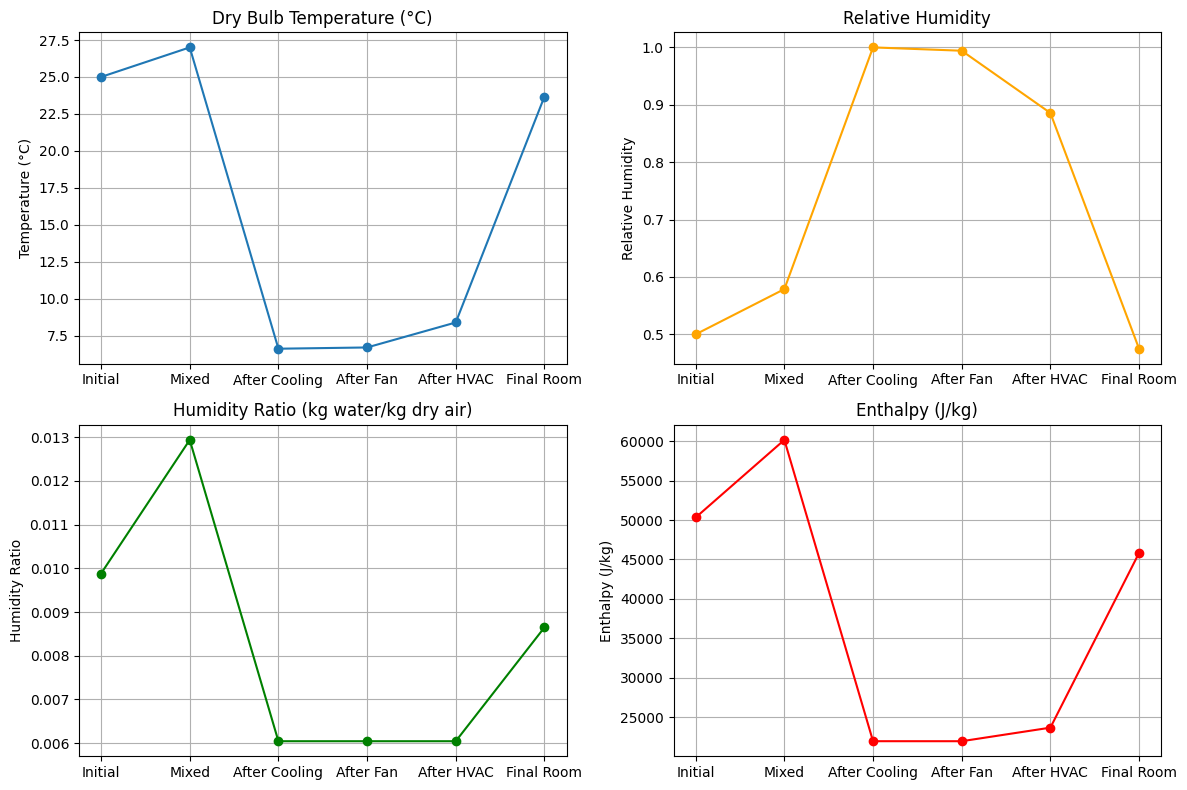

In [9]:
# prompt: plot T,RH,W,h for each step initial, mixed, after cooling, after fan, after hvac, final room

import matplotlib.pyplot as plt

# Data points for plotting
steps = ["Initial", "Mixed", "After Cooling", "After Fan", "After HVAC", "Final Room"]
temperatures = [T_room, T_MA, T_Coil, T_fan, T_Out, T_final]
humidities = [RH_room, RH_MA, RH_Coil, RH_fan, RH_Out, RH_final]
humidity_ratios = [W_room, W_MA, W_Coil, W_fan, W_Out, W_final]
enthalpies = [h_room, h_MA, h_Coil, h_fan, h_Out, h_final]

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(steps, temperatures, marker='o')
plt.title("Dry Bulb Temperature (°C)")
plt.ylabel("Temperature (°C)")
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(steps, humidities, marker='o', color='orange')
plt.title("Relative Humidity")
plt.ylabel("Relative Humidity")
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(steps, humidity_ratios, marker='o', color='green')
plt.title("Humidity Ratio (kg water/kg dry air)")
plt.ylabel("Humidity Ratio")
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(steps, enthalpies, marker='o', color='red')
plt.title("Enthalpy (J/kg)")
plt.ylabel("Enthalpy (J/kg)")
plt.grid(True)

plt.tight_layout()
plt.show()


# Python Object

In [12]:
import psychrolib as psy
import numpy as np
import math

class HVACSimulation:
    def __init__(self,
                 # Control Signal
                 Control_Air_AF=0.5, Control_Vent_AF=0.1, Control_Cooling_PW=0.9, Control_Heating_PW=0.1,
                 # Room Config
                 dt=600, N_Occ=3, Q_Equ=500, T_room=25, RH_room=0.5, P_air=101325,
                 L_room=5, W_room=4, H_room=2.5, A_window=4,
                 # Weather Data
                 T_out=35, RH_out=0.7,
                 # AHU Config
                 Max_Air_FR=0.1, P_fan=5.0, Max_Vent_FR=0.1, Max_Cooling_PW=2500, Max_Heating_PW=1000,
                 # Standard Definitions
                 Q_S_Per_Occ=200 * 0.293, Q_L_Per_Occ=180 * 0.293, Q_L_Other=0,
                 U_wall=0.284, U_window=1.987,
                 # Constants
                 h_fg_room=2441000, Cp_Air=1005):
        # Control Signal
        self.Control_Air_AF = Control_Air_AF  # 0 ~ 1
        self.Control_Vent_AF = Control_Vent_AF  # 0 ~ 1
        self.Control_Cooling_PW = Control_Cooling_PW  # 0 ~ 1
        self.Control_Heating_PW = Control_Heating_PW  # 0 ~ 1

        # Room Config
        self.dt = dt  # s Time to simulate
        self.N_Occ = N_Occ  # Number of Occupants in the room
        self.Q_Equ = Q_Equ  # W - Sensible Heat from Equipment/Lights
        self.T_room = T_room  # °C - Initial dry bulb temperature
        self.RH_room = RH_room  # 0 ~ 1 - Initial relative humidity
        self.P_air = P_air  # Pa - Atmospheric pressure (sea level)
        self.L_room = L_room  # m - Length of the room
        self.W_room = W_room  # m - Width of the room
        self.H_room = H_room  # m - Height of the room
        self.A_window = A_window  # m^2 - Area of the window
        self.A_wall = (L_room + W_room) * H_room - A_window  # m^2 - Area of the wall
        self.V_room = L_room * W_room * H_room  # m^3 - Volume of the room

        # Weather Data
        self.T_out = T_out  # °C - Outside temperature
        self.RH_out = RH_out  # 0 ~ 1 - Outside relative humidity

        # AHU Config
        self.Max_Air_FR = Max_Air_FR  # m^3/s Maximum airflow rate
        self.P_fan = P_fan  # W Fan power
        self.Max_Vent_FR = Max_Vent_FR  # m^3/s Maximum ventilation airflow rate
        self.Max_Cooling_PW = Max_Cooling_PW  # W Maximum Cooling load
        self.Max_Heating_PW = Max_Heating_PW  # W Maximum heating load

        # Standard Definitions
        self.Q_S_Per_Occ = Q_S_Per_Occ  # W - Sensible Heat from Occupants
        self.Q_L_Per_Occ = Q_L_Per_Occ  # W - Latent Heat from Occupants
        self.Q_L_Other = Q_L_Other  # W - Other latent heat sources
        self.U_wall = U_wall  # W/m^2.K
        self.U_window = U_window  # W/m^2.K

        # Constants
        self.h_fg_room = h_fg_room  # J/kg
        self.Cp_Air = Cp_Air  # J/kg-K

    def calculate_room_conditions(self):
        """Calculate initial room conditions."""
        self.W_room = psy.GetHumRatioFromRelHum(self.T_room, self.RH_room, self.P_air)  # kg water/kg dry air
        self.h_room = psy.GetMoistAirEnthalpy(self.T_room, self.W_room)  # J/kg
        self.p_air = psy.GetMoistAirDensity(self.T_room, self.W_room, self.P_air)  # kg/m^3
        self.W_out = psy.GetHumRatioFromRelHum(self.T_out, self.RH_out, self.P_air)  # kg water/kg dry air

    def calculate_calculated_parameters(self):
        """Calculate airflow and power parameters."""
        self.Air_AF = self.Max_Air_FR * self.Control_Air_AF  # m^3/s
        self.Vent_AF = self.Max_Air_FR * self.Control_Vent_AF  # m^3/s
        self.Cooling_PW = self.Max_Cooling_PW * self.Control_Cooling_PW  # W
        self.Heating_PW = self.Max_Heating_PW * self.Control_Heating_PW  # W

    def calculate_heat_loads(self):
        """Calculate total sensible and latent heat loads."""
        self.Q_S_envelope = self.U_wall * self.A_wall * (self.T_out - self.T_room) + \
                           self.U_window * self.A_window * (self.T_out - self.T_room)  # W
        self.Q_S_total = self.Q_S_Per_Occ * self.N_Occ + self.Q_Equ + self.Q_S_envelope  # W
        self.Q_L_total = self.Q_L_Per_Occ * self.N_Occ + self.Q_L_Other  # W

    def calculate_mixed_air(self):
        """Calculate mixed air conditions."""
        self.T_MA = (self.Vent_AF * self.T_out + (self.Air_AF - self.Vent_AF) * self.T_room) / self.Air_AF
        self.W_MA = (self.Vent_AF * self.W_out + (self.Air_AF - self.Vent_AF) * self.W_room) / self.Air_AF
        self.RH_MA = psy.GetRelHumFromHumRatio(self.T_MA, max(self.W_MA, 0), self.P_air)
        self.h_MA = psy.GetMoistAirEnthalpy(self.T_MA, max(self.W_MA, 0))  # J/kg

    def calculate_cooling_coil(self):
        """Simulate cooling coil process."""
        self.h_Coil = self.h_MA - (self.Cooling_PW / (self.p_air * self.Air_AF))
        RH_Coil = 1.0  # Assume saturation
        T_min, T_max = 5.0, 20.0  # °C
        T_step = 0.01
        tolerance = 100  # J/kg

        self.T_Coil = None
        self.W_Coil = None
        for T in np.arange(T_min, T_max, T_step):
            W = psy.GetHumRatioFromRelHum(T, RH_Coil, self.P_air)
            h = psy.GetMoistAirEnthalpy(T, W)
            if abs(h - self.h_Coil) < tolerance:
                self.T_Coil = T
                self.W_Coil = W
                break
        self.RH_Coil = psy.GetRelHumFromHumRatio(self.T_Coil, max(self.W_Coil, 0), self.P_air)
        self.T_dew = psy.GetTDewPointFromRelHum(self.T_Coil, self.RH_Coil)

    def calculate_fan_heat(self):
        """Calculate fan heat addition."""
        self.ΔT_fan = self.P_fan / (self.p_air * self.Cp_Air * self.Air_AF)
        self.T_fan = self.T_Coil + self.ΔT_fan
        self.W_fan = self.W_Coil
        self.RH_fan = psy.GetRelHumFromHumRatio(self.T_fan, self.W_fan, self.P_air)
        self.h_fan = psy.GetMoistAirEnthalpy(self.T_fan, self.W_fan)

    def calculate_heating_coil(self):
        """Simulate heating coil process."""
        self.T_Out = self.T_fan + (self.Heating_PW / (self.p_air * self.Cp_Air * self.Air_AF))
        self.W_Out = self.W_fan
        self.RH_Out = psy.GetRelHumFromHumRatio(self.T_Out, max(self.W_Out, 0), self.P_air)
        self.h_Out = psy.GetMoistAirEnthalpy(self.T_Out, max(self.W_Out, 0))  # J/kg

    def calculate_final_conditions(self):
        """Calculate final room air conditions."""
        self.T_final = (self.T_Out + self.Q_S_total / (self.p_air * self.Cp_Air * self.Air_AF) +
                       (self.T_room - self.T_Out - (self.Q_S_total / (self.p_air * self.Cp_Air * self.Air_AF))) *
                       math.exp(-(self.Air_AF / self.V_room) * self.dt))
        self.W_final = (self.W_Out + self.Q_L_total / (self.p_air * self.h_fg_room * self.Air_AF) +
                       (self.W_room - self.W_Out - (self.Q_L_total / (self.p_air * self.h_fg_room * self.Air_AF))) *
                       math.exp(-(self.Air_AF / self.V_room) * self.dt))
        self.RH_final = psy.GetRelHumFromHumRatio(self.T_final, max(self.W_final, 0), self.P_air)
        self.h_final = psy.GetMoistAirEnthalpy(self.T_final, max(self.W_final, 0))  # J/kg

    def calculate_energy_consumption(self):
        """Calculate energy consumption."""
        self.E_fan = self.P_fan * self.dt  # J
        self.E_cooling = self.Cooling_PW * self.dt  # J
        self.E_heating = self.Heating_PW * self.dt  # J
        self.E_fan_kWh = self.E_fan / 3.6e6
        self.E_cooling_kWh = self.E_cooling / 3.6e6
        self.E_heating_kWh = self.E_heating / 3.6e6
        self.E_total_kWh = self.E_fan_kWh + self.E_cooling_kWh + self.E_heating_kWh

    def run_simulation(self):
        """Run the full simulation and print results."""
        self.calculate_room_conditions()
        self.calculate_calculated_parameters()
        self.calculate_heat_loads()

        print("Parameters")
        print(f"Q_S_Per_Occ: {self.Q_S_Per_Occ} W")
        print(f"Q_L_Per_Occ: {self.Q_L_Per_Occ} W")
        print(f"W_room: {self.W_room} kg water/kg dry air")
        print(f"h_room: {self.h_room} J/kg")
        print(f"h_fg_room: {self.h_fg_room} J/kg")
        print(f"p_air: {self.p_air} kg/m^3")
        print(f"Cp_Air: {self.Cp_Air} kJ/kg-K")
        print("")

        print("Total Room Sensible and Latent Heat Loads")
        print(f"Q_S_envelope: {self.Q_S_envelope} W")
        print(f"Q_S_total: {self.Q_S_total} W")
        print(f"Q_L_total: {self.Q_L_total} W")
        print("")

        print("Room air")
        print(f"T_room: {self.T_room} °C")
        print(f"W_room: {self.W_room} kg water/kg dry air")
        print(f"RH_room: {self.RH_room}")
        print(f"hg_room: {self.h_room} J/kg")
        print("")

        self.calculate_mixed_air()
        print("Mixed Air Dry-bulb Temperature (T_MA)")
        print(f"T_MA: {self.T_MA} °C")
        print(f"W_MA: {self.W_MA} kg water/kg dry air")
        print(f"RH_MA: {self.RH_MA}")
        print(f"h_MA: {self.h_MA} J/kg")
        print("")

        self.calculate_cooling_coil()
        print("Air Condition After Cooling Coil")
        print(f"T_Coil: {self.T_Coil} °C")
        print(f"W_Coil: {self.W_Coil} kg water/kg dry air")
        print(f"RH_Coil: {self.RH_Coil}")
        print(f"h_Coil: {self.h_Coil} J/kg")
        print(f"T_dew: {self.T_dew} °C")
        print("")

        self.calculate_fan_heat()
        print("Fan Heat Addition (for Draw-Through AHU)")
        print(f"ΔT_fan: {self.ΔT_fan} °C")
        print("")
        print(f"T_fan: {self.T_fan} °C")
        print(f"W_fan: {self.W_fan} kg water/kg dry air")
        print(f"RH_fan: {self.RH_fan}")
        print(f"h_fan: {self.h_fan} J/kg")
        print("")

        self.calculate_heating_coil()
        print("Simulate Heating Coil Process and Determine Final Supply Air Conditions")
        print(f"T_Out: {self.T_Out} °C")
        print(f"W_Out: {self.W_Out} kg water/kg dry air")
        print(f"RH_Out: {self.RH_Out}")
        print(f"h_Out: {self.h_Out} J/kg")
        print("")

        self.calculate_final_conditions()
        print("Simulate Final Air Temp")
        print(f"T_final: {self.T_final} °C")
        print(f"W_final: {self.W_final} kg water/kg dry air")
        print(f"RH_final: {self.RH_final}")
        print(f"h_final: {self.h_final} J/kg")
        print("")

        self.calculate_energy_consumption()
        print("Energy Consumption")
        print(f"Fan Energy: {self.E_fan_kWh:.6f} kWh")
        print(f"Cooling Energy: {self.E_cooling_kWh:.6f} kWh")
        print(f"Heating Energy: {self.E_heating_kWh:.6f} kWh")
        print(f"Total Energy: {self.E_total_kWh:.6f} kWh")

if __name__ == "__main__":
    sim = HVACSimulation()
    sim.run_simulation()

Parameters
Q_S_Per_Occ: 58.599999999999994 W
Q_L_Per_Occ: 52.739999999999995 W
W_room: 0.009881043690749623 kg water/kg dry air
h_room: 50321.958802184665 J/kg
h_fg_room: 2441000 J/kg
p_air: 1.17695818641638 kg/m^3
Cp_Air: 1005 kJ/kg-K

Total Room Sensible and Latent Heat Loads
Q_S_envelope: 132.01999999999998 W
Q_S_total: 807.8199999999999 W
Q_L_total: 158.21999999999997 W

Room air
T_room: 25 °C
W_room: 0.009881043690749623 kg water/kg dry air
RH_room: 0.5
hg_room: 50321.958802184665 J/kg

Mixed Air Dry-bulb Temperature (T_MA)
T_MA: 27.0 °C
W_MA: 0.012936662590369461 kg water/kg dry air
RH_MA: 0.5787686569624064
h_MA: 60166.27233380238 J/kg

Air Condition After Cooling Coil
T_Coil: 6.609999999999966 °C
W_Coil: 0.006045676287111269 kg water/kg dry air
RH_Coil: 1.0
h_Coil: 21932.118801962242 J/kg
T_dew: 6.609999999999966 °C

Fan Heat Addition (for Draw-Through AHU)
ΔT_fan: 0.0845420752500611 °C

T_fan: 6.694542075250027 °C
W_fan: 0.006045676287111269 kg water/kg dry air
RH_fan: 0.99419

In [44]:
import psychrolib as psy
import numpy as np
import math

class HVACSimulation:
    def __init__(self,
                 # Room Config (Fixed)
                 dt=600, P_air=101325, L_room=5, W_room=4, H_room=2.5, A_window=4,
                 # AHU Config (Fixed)
                 Max_Air_FR=0.1, P_fan=5.0, Max_Vent_FR=0.1, Max_Cooling_PW=2500, Max_Heating_PW=1000,
                 # Standard Definitions (Fixed)
                 Q_S_Per_Occ=200 * 0.293, Q_L_Per_Occ=180 * 0.293, Q_L_Other=0,
                 U_wall=0.284, U_window=1.987,
                 # Constants (Fixed)
                 h_fg_room=2441000, Cp_Air=1005):
        # Room Config
        self.dt = dt  # s Time to simulate
        self.P_air = P_air  # Pa - Atmospheric pressure (sea level)
        self.L_room = L_room  # m - Length of the room
        self.W_room = W_room  # m - Width of the room
        self.H_room = H_room  # m - Height of the room
        self.A_window = A_window  # m^2 - Area of the window
        self.A_wall = (L_room + W_room) * H_room - A_window  # m^2 - Area of the wall
        self.V_room = L_room * W_room * H_room  # m^3 - Volume of the room

        # AHU Config
        self.Max_Air_FR = Max_Air_FR  # m^3/s Maximum airflow rate
        self.P_fan = P_fan  # W Fan power
        self.Max_Vent_FR = Max_Vent_FR  # m^3/s Maximum ventilation airflow rate
        self.Max_Cooling_PW = Max_Cooling_PW  # W Maximum Cooling load
        self.Max_Heating_PW = Max_Heating_PW  # W Maximum heating load

        # Standard Definitions
        self.Q_S_Per_Occ = Q_S_Per_Occ  # W - Sensible Heat from Occupants
        self.Q_L_Per_Occ = Q_L_Per_Occ  # W - Latent Heat from Occupants
        self.Q_L_Other = Q_L_Other  # W - Other latent heat sources
        self.U_wall = U_wall  # W/m^2.K
        self.U_window = U_window  # W/m^2.K

        # Constants
        self.h_fg_room = h_fg_room  # J/kg
        self.Cp_Air = Cp_Air  # J/kg-K

    def calculate_room_conditions(self, T_room, RH_room, T_out, RH_out):
        """Calculate initial room conditions."""
        self.W_room = psy.GetHumRatioFromRelHum(T_room, max(RH_room, 0), self.P_air)  # kg water/kg dry air
        self.h_room = psy.GetMoistAirEnthalpy(T_room, self.W_room)  # J/kg
        self.p_air = psy.GetMoistAirDensity(T_room, self.W_room, self.P_air)  # kg/m^3
        self.W_out = psy.GetHumRatioFromRelHum(T_out, RH_out, self.P_air)  # kg water/kg dry air

    def calculate_calculated_parameters(self, Control_Air_AF, Control_Vent_AF, Control_Cooling_PW, Control_Heating_PW):
        """Calculate airflow and power parameters."""
        self.Air_AF = self.Max_Air_FR * Control_Air_AF  # m^3/s
        self.Vent_AF = self.Max_Air_FR * Control_Vent_AF  # m^3/s
        self.Cooling_PW = self.Max_Cooling_PW * Control_Cooling_PW  # W
        self.Heating_PW = self.Max_Heating_PW * Control_Heating_PW  # W

    def calculate_heat_loads(self, N_Occ, Q_Equ, T_room, T_out):
        """Calculate total sensible and latent heat loads."""
        self.Q_S_envelope = self.U_wall * self.A_wall * (T_out - T_room) + \
                           self.U_window * self.A_window * (T_out - T_room)  # W
        self.Q_S_total = self.Q_S_Per_Occ * N_Occ + Q_Equ + self.Q_S_envelope  # W
        self.Q_L_total = self.Q_L_Per_Occ * N_Occ + self.Q_L_Other  # W

    def calculate_mixed_air(self):
        """Calculate mixed air conditions."""
        self.T_MA = (self.Vent_AF * self.T_out + (self.Air_AF - self.Vent_AF) * self.T_room) / self.Air_AF
        self.W_MA = (self.Vent_AF * self.W_out + (self.Air_AF - self.Vent_AF) * self.W_room) / self.Air_AF
        self.RH_MA = psy.GetRelHumFromHumRatio(self.T_MA, max(self.W_MA, 0), self.P_air)
        self.h_MA = psy.GetMoistAirEnthalpy(self.T_MA, max(self.W_MA, 0))  # J/kg

    def calculate_cooling_coil(self):
        """Simulate cooling coil process."""
        self.h_Coil = self.h_MA - (self.Cooling_PW / (self.p_air * self.Air_AF))
        RH_Coil = 1.0  # Assume saturation
        T_min, T_max = 0.0, 60.0  # °C
        T_step = 0.01
        tolerance = 100  # J/kg

        self.T_Coil = None
        self.W_Coil = None
        for T in np.arange(T_min, T_max, T_step):
            W = psy.GetHumRatioFromRelHum(T, RH_Coil, self.P_air)
            h = psy.GetMoistAirEnthalpy(T, W)
            if abs(h - self.h_Coil) < tolerance:
                self.T_Coil = T
                self.W_Coil = W
                break
        self.RH_Coil = psy.GetRelHumFromHumRatio(self.T_Coil, max(self.W_Coil, 0), self.P_air)
        self.T_dew = psy.GetTDewPointFromRelHum(self.T_Coil, self.RH_Coil)

    def calculate_fan_heat(self):
        """Calculate fan heat addition."""
        self.ΔT_fan = self.P_fan / (self.p_air * self.Cp_Air * self.Air_AF)
        self.T_fan = self.T_Coil + self.ΔT_fan
        self.W_fan = self.W_Coil
        self.RH_fan = psy.GetRelHumFromHumRatio(self.T_fan, max(self.W_fan, 0), self.P_air)
        self.h_fan = psy.GetMoistAirEnthalpy(self.T_fan, self.W_fan)

    def calculate_heating_coil(self):
        """Simulate heating coil process."""
        self.T_Out = self.T_fan + (self.Heating_PW / (self.p_air * self.Cp_Air * self.Air_AF))
        self.W_Out = self.W_fan
        self.RH_Out = psy.GetRelHumFromHumRatio(self.T_Out, max(self.W_Out, 0), self.P_air)
        self.h_Out = psy.GetMoistAirEnthalpy(self.T_Out, max(self.W_Out, 0))  # J/kg

    def calculate_final_conditions(self):
        """Calculate final room air conditions."""
        self.T_final = (self.T_Out + self.Q_S_total / (self.p_air * self.Cp_Air * self.Air_AF) +
                       (self.T_room - self.T_Out - (self.Q_S_total / (self.p_air * self.Cp_Air * self.Air_AF))) *
                       math.exp(-(self.Air_AF / self.V_room) * self.dt))
        self.W_final = (self.W_Out + self.Q_L_total / (self.p_air * self.h_fg_room * self.Air_AF) +
                       (self.W_room - self.W_Out - (self.Q_L_total / (self.p_air * self.h_fg_room * self.Air_AF))) *
                       math.exp(-(self.Air_AF / self.V_room) * self.dt))
        self.RH_final = psy.GetRelHumFromHumRatio(self.T_final, max(self.W_final, 0), self.P_air)
        self.h_final = psy.GetMoistAirEnthalpy(self.T_final, max(self.W_final, 0))  # J/kg

    def calculate_energy_consumption(self):
        """Calculate energy consumption."""
        self.E_fan = self.P_fan * self.dt  # J
        self.E_cooling = self.Cooling_PW * self.dt  # J
        self.E_heating = self.Heating_PW * self.dt  # J
        self.E_fan_kWh = self.E_fan / 3.6e6
        self.E_cooling_kWh = self.E_cooling / 3.6e6
        self.E_heating_kWh = self.E_heating / 3.6e6
        self.E_total_kWh = self.E_fan_kWh + self.E_cooling_kWh + self.E_heating_kWh

    def run_simulation(self,
                       Control_Air_AF=0.5, Control_Vent_AF=0.1, Control_Cooling_PW=0.9, Control_Heating_PW=0.1,
                       N_Occ=3, Q_Equ=500, T_room=25, RH_room=0.5, T_out=35, RH_out=0.7):
        """Run the full simulation and return results as a dictionary."""
        # Store input parameters
        self.Control_Air_AF = Control_Air_AF
        self.Control_Vent_AF = Control_Vent_AF
        self.Control_Cooling_PW = Control_Cooling_PW
        self.Control_Heating_PW = Control_Heating_PW
        self.N_Occ = N_Occ
        self.Q_Equ = Q_Equ
        self.T_room = T_room
        self.RH_room = RH_room
        self.T_out = T_out
        self.RH_out = RH_out

        # Run calculations
        self.calculate_room_conditions(T_room, RH_room, T_out, RH_out)
        self.calculate_calculated_parameters(Control_Air_AF, Control_Vent_AF, Control_Cooling_PW, Control_Heating_PW)
        self.calculate_heat_loads(N_Occ, Q_Equ, T_room, T_out)
        self.calculate_mixed_air()
        self.calculate_cooling_coil()
        self.calculate_fan_heat()
        self.calculate_heating_coil()
        self.calculate_final_conditions()
        self.calculate_energy_consumption()

        # Organize results
        results = {
            # Top-level: Input parameters and key results
            'Control_Air_AF': self.Control_Air_AF,
            'Control_Vent_AF': self.Control_Vent_AF,
            'Control_Cooling_PW': self.Control_Cooling_PW,
            'Control_Heating_PW': self.Control_Heating_PW,
            'N_Occ': self.N_Occ,
            'Q_Equ': self.Q_Equ,
            'T_room': self.T_room,
            'RH_room': self.RH_room,
            'T_out': self.T_out,
            'RH_out': self.RH_out,
            'T_final': self.T_final,
            'W_final': self.W_final,
            'RH_final': self.RH_final,
            'h_final': self.h_final,
            'E_total_kWh': self.E_total_kWh,
            # Secondary-level: Intermediate calculations
            'secondary_data': {
                'Q_S_Per_Occ': self.Q_S_Per_Occ,
                'Q_L_Per_Occ': self.Q_L_Per_Occ,
                'W_room': self.W_room,
                'h_room': self.h_room,
                'h_fg_room': self.h_fg_room,
                'p_air': self.p_air,
                'Cp_Air': self.Cp_Air,
                'Q_S_envelope': self.Q_S_envelope,
                'Q_S_total': self.Q_S_total,
                'Q_L_total': self.Q_L_total,
                'T_MA': self.T_MA,
                'W_MA': self.W_MA,
                'RH_MA': self.RH_MA,
                'h_MA': self.h_MA,
                'T_Coil': self.T_Coil,
                'W_Coil': self.W_Coil,
                'RH_Coil': self.RH_Coil,
                'h_Coil': self.h_Coil,
                'T_dew': self.T_dew,
                'ΔT_fan': self.ΔT_fan,
                'T_fan': self.T_fan,
                'W_fan': self.W_fan,
                'RH_fan': self.RH_fan,
                'h_fan': self.h_fan,
                'T_Out': self.T_Out,
                'W_Out': self.W_Out,
                'RH_Out': self.RH_Out,
                'h_Out': self.h_Out,
                'E_fan_kWh': self.E_fan_kWh,
                'E_cooling_kWh': self.E_cooling_kWh,
                'E_heating_kWh': self.E_heating_kWh
            }
        }
        return results

# if __name__ == "__main__":
#     sim = HVACSimulation()
#     results = sim.run_simulation()
#     # Example of accessing results
#     print("Top-level results:")
#     for key, value in results.items():
#         if key != 'secondary_data':
#             print(f"{key}: {value}")
#     print("\nSecondary data:")
#     for key, value in results['secondary_data'].items():
#         print(f"{key}: {value}")

In [49]:
sim = HVACSimulation()
results = sim.run_simulation(
)
print(results['T_final'])  # Access final temperature
print(results['secondary_data']['Q_S_total'])  # Access intermediate sensible heat load

23.66644034133396
807.8199999999999
